$\newcommand{\Sum}{\sum\limits}
\newcommand{\Int}{\int\limits}
\newcommand{\Intf}{\int\limits_{-\infty}^{+\infty}}
\newcommand{\Prod}{\prod\limits}
\newcommand{\Max}{\max\limits}
\newcommand{\Min}{\min\limits}
\newcommand{\Lim}{\lim\limits}
\newcommand{\Var}{\mathbb{V}}
\newcommand{\Exp}{\mathbb{E}}
\newcommand{\argmax}{\arg\max}
\newcommand{\Cov}{\mathrm{Cov}}
\newcommand{\makebold}[1]{\boldsymbol{#1}}
\newcommand{\mean}[1]{\overline{#1}}
\newcommand{\Prob}{\mathcal{P}}
\newcommand{\lp}{\left}
\newcommand{\rp}{\right}
\newcommand{\boldX}{\boldsymbol{X}}
\newcommand{\boldY}{\boldsymbol{Y}}
\newcommand{\boldZ}{\boldsymbol{Z}}
\newcommand{\Poisson}{\mathrm{Poisson}}
\newcommand{\Uniform}{\mathrm{Uniform}}
\newcommand{\Binomial}{\mathrm{Binomial}}
\newcommand{\Gammap}{\mathrm{Gamma}}
\newcommand{\Normal}{\mathcal{N}}
\newcommand{\LogN}{\mathrm{LogN}}
\newcommand{\Exponential}{\mathrm{Exp}}
\newcommand{\Erlang}{\mathrm{Erlang}}
\newcommand{\Cauchy}{C}$

## Математическая статистика в машинном обучении

## Д/З №4

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import tqdm.notebook as tq
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor

import warnings
warnings.filterwarnings("ignore")

## Задача 7: подбор гиперпараметров модели байесовской оптимизацией

#### Создание датасета и разбивка трейн/тест

In [2]:
X, y = make_classification(n_samples=1000, 
                           n_features=20, 
                           n_informative=15, 
                           n_redundant=5, 
                           n_classes=2,
                           random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
X_train.shape[0], X_test.shape[0]

(500, 500)

#### Модель Kernel SVM с RBF-ядром, сетка параметров для $(C, \gamma)$

In [3]:
model = SVC(kernel='rbf', 
            C=1.0, 
            gamma=0.05,  
            probability=True,
            random_state=42)
n = 71
C_grid = np.logspace(-4, 3, n)
gamma_grid = np.logspace(-4, 3, n)

In [4]:
def get_score(model, C, gamma, X_train, y_train, X_test, y_test):
    model.set_params(**{'C': C, 'gamma': gamma})
    model.fit(X_train, y_train)
    y_pred = model.decision_function(X_test)
    return roc_auc_score(y_test, y_pred)

#### Визуализация ROC-AUC на тесте при поиске по сетке параметров полным перебором (GridSearch)

In [5]:
roc_aucs = np.zeros(shape=(n, n))

for index_c, C in tq.tqdm(enumerate(C_grid), total=n):
    for index_g, gamma in enumerate(gamma_grid):
        roc_aucs[index_g, index_c] = get_score(model, C, gamma, X_train, y_train, X_test, y_test)

  0%|          | 0/71 [00:00<?, ?it/s]

In [6]:
index_g, index_c = np.unravel_index(roc_aucs.argmax(), roc_aucs.shape)
best_C_gs = C_grid[index_c]
best_gamma_gs = gamma_grid[index_g]
print(f'Best ROC-AUC: {roc_aucs[index_g, index_c]:.4f} (C={best_C_gs}, gamma={best_gamma_gs})')

Best ROC-AUC: 0.9849 (C=1.9952623149688788, gamma=0.01)


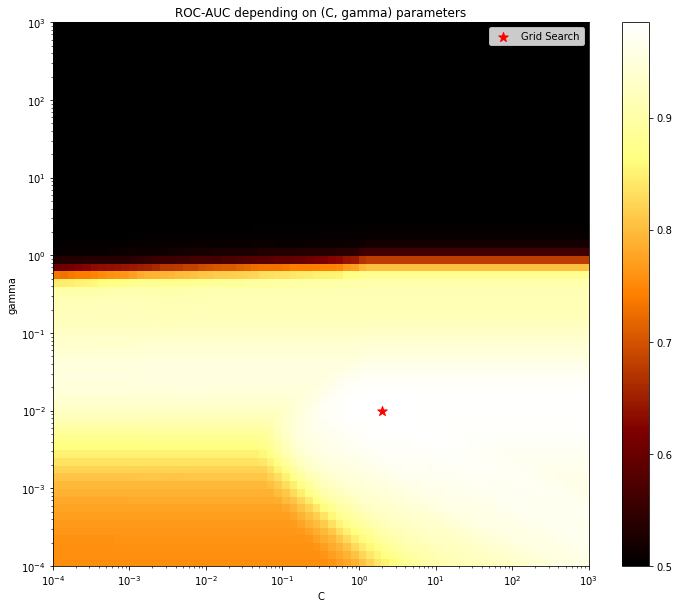

In [7]:
XX, YY = np.meshgrid(C_grid, gamma_grid)
plt.figure(figsize=(12, 10))
plt.pcolormesh(XX, YY, roc_aucs, cmap='afmhot')
plt.colorbar()
plt.scatter([best_C_gs], [best_gamma_gs], marker='*', color='r', s=100, label='Grid Search')
plt.title('ROC-AUC depending on (C, gamma) parameters')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('C')
plt.ylabel('gamma')
plt.legend();

#### Алгоритм подбора параметров $(C, \gamma)$  байесовской оптимизацией

* Определим начальный сэмпл из 10 значений $(C, \gamma)$ и выберем из них с лучшим качеством

In [8]:
m = 701
C_grid_bayes = np.logspace(-4, 3, m)
gamma_grid_bayes = np.logspace(-4, 3, m)
grid_bayes = np.vstack(product(C_grid_bayes, gamma_grid_bayes))
np.random.seed(42)

size = 10
random_indices = list(np.random.randint(0, m*m, size))
params_sample = grid_bayes[random_indices]
scores = []

for C, gamma in params_sample:
    score = get_score(model, C, gamma, X_train, y_train, X_test, y_test)
    scores.append(score)

In [10]:
i = np.argmax(scores)
best_C, best_gamma = params_sample[i]
best_score = np.max(scores)

print(f'Sample best ROC-AUC: {best_score:.4f} (C={best_C}, gamma={best_gamma})')

Sample best ROC-AUC: 0.9420 (C=0.003715352290971728, gamma=0.012882495516931335)


* Выполним оптимизацию, обучая гауссовскую регрессию для подмножестве параметров, соответствующих наибольшим std целевой переменной roc_auc

In [11]:
max_iter = 100
var_threshold = 0.01
kernel = RBF() + WhiteKernel()

for n_iter in  tq.tqdm(range(max_iter)):
    gpr = GaussianProcessRegressor(kernel, random_state=42, n_restarts_optimizer=10)
    gpr.fit(np.log(params_sample), scores)
    pred, stds = gpr.predict(np.log(grid_bayes), return_std=True)
    C, gamma = grid_bayes[np.argmax(stds)]
    score = get_score(model, C, gamma, X_train, y_train, X_test, y_test)
    
    scores.append(score)
    params_sample = np.vstack([params_sample, [C, gamma]])
    
    if all(stds < var_threshold):
        print(f'All of stds are below {var_threshold}, finish!')
        break

    if score > best_score:
        best_C = C
        best_gamma = gamma
        best_score = score
        print(f'New best ROC-AUC: {best_score:.4f}!')
    
print(f'Best ROC-AUC: {best_score:.4f} (C={best_C}, gamma={best_gamma})')

  0%|          | 0/100 [00:00<?, ?it/s]

New best ROC-AUC: 0.9596!
New best ROC-AUC: 0.9812!
New best ROC-AUC: 0.9818!
New best ROC-AUC: 0.9836!
Best ROC-AUC: 0.9836 (C=5.011872336272725, gamma=0.006456542290346556)


#### Сравним полный перебор и байесовскую оптимизацию

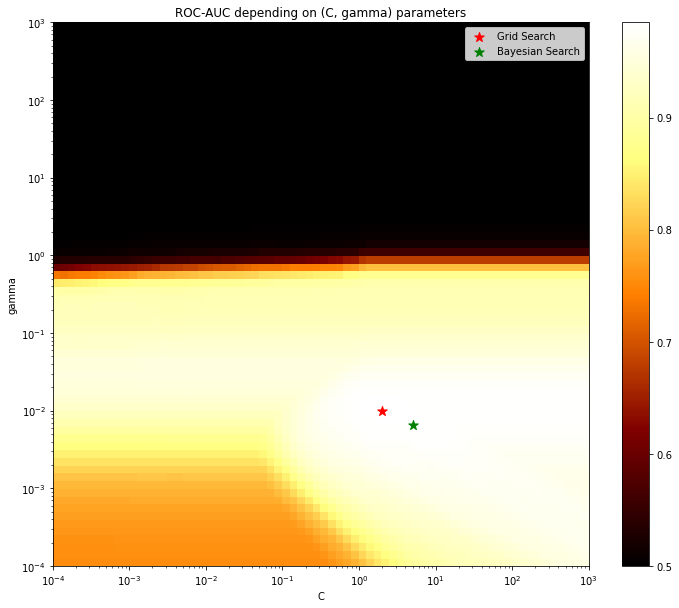

In [12]:
XX, YY = np.meshgrid(C_grid, gamma_grid)
plt.figure(figsize=(12, 10))
plt.pcolormesh(XX, YY, roc_aucs, cmap='afmhot')
plt.colorbar()
plt.scatter([best_C_gs], [best_gamma_gs], marker='*', color='r', s=100, label='Grid Search')
plt.scatter([best_C], [best_gamma], marker='*', color='g', s=100, label='Bayesian Search')
plt.title('ROC-AUC depending on (C, gamma) parameters')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('C')
plt.ylabel('gamma')
plt.legend();

__Выводы:__

* Grid Search дал ROC-AUC __0.9849__ за __~12__ минут поиска по сетке __71х71__
* Bayesian Seach дошел до схожего ROC-AUC __0.9836__ за __~2__ минуты поиска по сетке __701х701__ и продолжает улучшаться